This notebook anaylses the NYC yellow taxi data. The data is provided in two files, train.csv and test.csv

The data is sampled from yellow taxi dataset for Jan-June 2016. Each entry in the dataset is information about a trip and contains values of the columns as mentioned in the data dictionary. 

# Data Dictionary

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in second

Similar types of taxi datasets have been used in different research. Like understanding the traffic patterns to make decisions, understand land use. Some studies have used taxi data to measure Social Functions of City Regions.

As seen in the previous research, taxi data not only helps in understanding the traffic movement but also help to understand the social function (land use) of the region. This project does a qualitative and quantitative analysis of the taxi dataset to understand the areas in NYC (Manhattan) with statistically significant patterns of taxi usage.

I have also created a predictive model for taxi trip duration.

# Importing required packages

In [5]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as sc
import datetime as dt
import shapely as sh
import geopandas as gp
import pysal as ps
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist


plt.rcParams['figure.figsize'] = [16, 10]
%matplotlib inline

# Reading in Data

In [7]:
filepath = "./NYC Taxi Trip Duration/"
train_file = "train.csv"
test_file = "test.csv"
train = pd.read_csv(filepath + train_file)
test = pd.read_csv(filepath + test_file)

# Other required datasets

The NYC Borough shapefile can be downloaded from this link - "https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nybb_17c.zip"

The NYC Census Tract shapefile can be downloaded from this link - https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_17c.zip


# Cleaning Data

The test data is missing the "dropoff_datetime" and "trip_duration" column

In [8]:
train.trip_duration.describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

## Please refer to the notebook 'NYC_trips_clean' for the code that cleans data
##### Trip durations which are abnormally high and low are removed. I have kept trips whose trip duration falls within 1 min and 3 std.deviations from mean and using ArcGis, I have selected all the points whose pickup and droppoffs fall within NYC, I have created a new train and test file 

In [11]:
train = pd.read_csv("./Cleaned_data/train.csv")
train.drop(['Unnamed: 0'], axis=1, inplace=True)

test = pd.read_csv("./Cleaned_data/test.csv")
test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
train = train[~train.iloc[:,1:].duplicated()]
train.reset_index(inplace=True, drop=True)

There are 5 duplicates present in the train data which have different id. I have removed these duplicates. To check which were these duplicates, use  "train[train.iloc[:,1:].duplicated(keep = False)]"

In [13]:
print "Number of unique train data id:",len(train.id.unique())
print "Number of NULL train data id:", train.id.isnull().sum()
print "Number of NULL test data id:", test.id.isnull().sum()

Number of unique train data id: 1441748
Number of NULL train data id: 0
Number of NULL test data id: 0


Since there are no NULL Ids and the other features have same no. of non-null values as the id, that means there are no NaN values in train and test data

In [14]:
# Converting datetime columns dtype from object to datetime
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [15]:
train.pickup_datetime.describe()

count                 1441748
unique                1364932
top       2016-01-12 18:48:44
freq                        5
first     2016-01-01 00:00:17
last      2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

In [16]:
train.dropoff_datetime.describe()

count                 1441748
unique                1365207
top       2016-02-19 19:25:04
freq                        5
first     2016-01-01 00:03:31
last      2016-07-01 00:48:20
Name: dropoff_datetime, dtype: object

In [17]:
test.pickup_datetime.describe()

count                  622383
unique                 607948
top       2016-02-04 19:54:06
freq                        4
first     2016-01-01 00:00:22
last      2016-06-30 23:59:58
Name: pickup_datetime, dtype: object

In [18]:
print "Trips with drop-off date on 1st July 2016:",len(train[train.dropoff_datetime >= '2016-07-01'])

Trips with drop-off date on 1st July 2016: 115


The train and test data have pickup date from 1st Jan to 30th June 2016. While the drop-off date is from 1st Jan to 1st July 2016. I guess some of the trips crossed date. There are 115 of these kind of trips

For our analysis, we are going to merge the train and test data to get a better sample for our analysis. The test data is missingh the trip duration and the dropoff datetime, analysis related to these two vatiables will be done only using train data

In [26]:
train = pd.concat([train, test], axis=0, ignore_index=True)

train.to_csv("./Cleaned_data/train_combined.csv")

### The taxi data provided is for only Yellow Taxis in NYC. 

There are three categorical variables: 1) vendor_id 2) store_and_fwd_flag 3) passenger_count

In [27]:
train.vendor_id.value_counts()

2    1104286
1     959845
Name: vendor_id, dtype: int64

There are two vendor categories: 1 and 2. From the data available the number of taxi trips by vendor 2 taxis is 15% more than the vendor 1 taxis. Further in the notebook, we will explore whether vendor id affects other variables  

In [34]:
train.store_and_fwd_flag.value_counts()

N    2052879
Y      11252
Name: store_and_fwd_flag, dtype: int64

The store_and_fwd_flag gives an idea about trips where the taxi had problems with connection. From the train and test data, we can see that almost 99.5% of the taxi trips had a proper connection. 0.5% times of the total trips had connection issues. We will further analyse this variable in the notebook. 

In [36]:
train.passenger_count.value_counts().sort_index()

0         30
1    1462613
2     297634
3      84843
4      40049
5     110628
6      68333
9          1
Name: passenger_count, dtype: int64

In [37]:
train = train[~train.passenger_count.isin([0, 7, 8, 9])]

As per the TLC guidlines, the number of passengers in a taxi can be 4 or 5 depending on the cab, however additional passengers can be added whose age is less than 7, so I have removed the entries with no. of passengers more than 6. I have also removed the entries where number of passengers is 0. These entries are faulty. Removing these entries wont affect the analysis much.  
Link to TLC FAQ - http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml

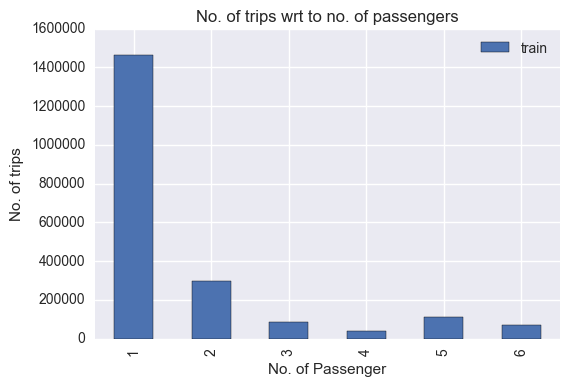

In [39]:
train.passenger_count.value_counts().sort_index().plot.bar(label = 'train')
plt.xlabel('No. of Passenger')
plt.ylabel('No. of trips')
plt.title('No. of trips wrt to no. of passengers')
plt.legend()

Figure 1: The figure shows that almost 70% trips in NYC have single passengers

#### Exploratory Analysis

Lets look at the individual variables

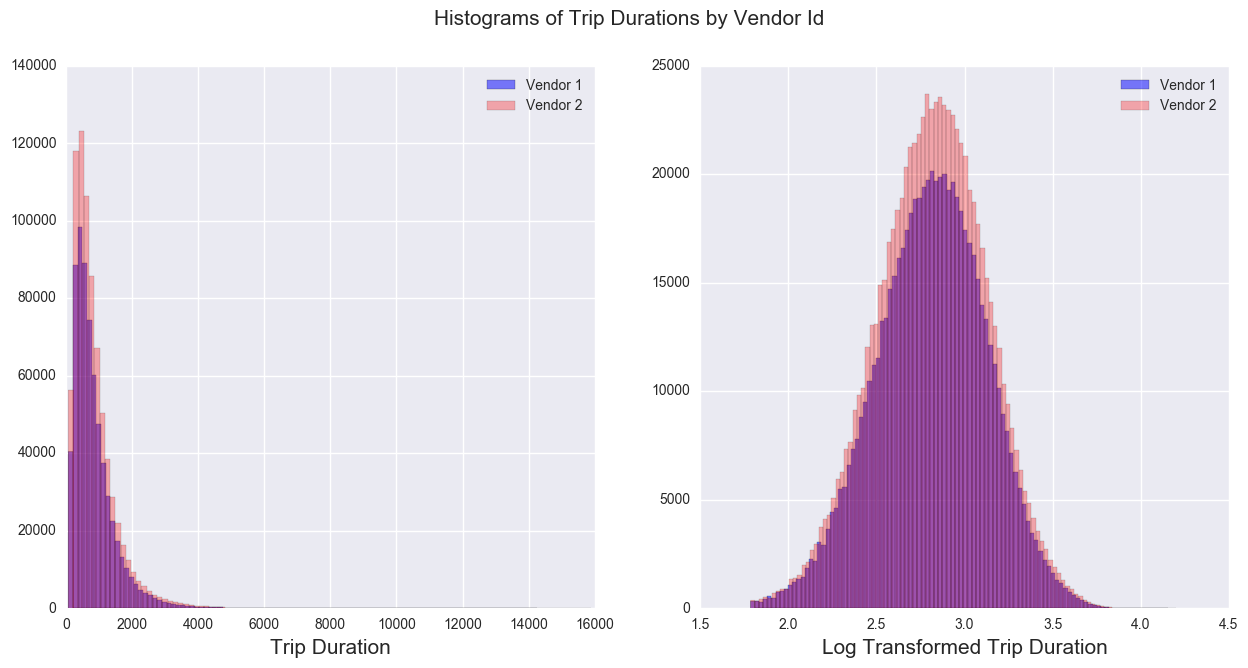

In [56]:
plt.figure(figsize=(15,7))


plt.subplot(1, 2, 1)
plt.hist(train[~train.trip_duration.isnull()][train.vendor_id==1].trip_duration,
         bins=100, alpha = 0.5, color = 'blue', label='Vendor 1', )
plt.hist(train[~train.trip_duration.isnull()][train.vendor_id==2].trip_duration,
         bins=100, alpha = 0.3, color = 'red', label='Vendor 2')
plt.xlabel('Trip Duration', size = 15)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.log10(train[~train.trip_duration.isnull()][train.vendor_id==1].trip_duration), 
         bins=100, alpha = 0.5, color = 'blue', label='Vendor 1')
plt.hist(np.log10(train[~train.trip_duration.isnull()][train.vendor_id==2].trip_duration),
         bins=100, alpha = 0.3, color = 'red', label='Vendor 2')
plt.xlabel('Log Transformed Trip Duration', size = 15)
plt.legend()

plt.suptitle('Histograms of Trip Durations by Vendor Id', size = 15)
plt.show()

Figure 2: The figure shows both original and log transformed distribution of trip durations in the train data for the two vendors. By visual inspection we can see that the mean and variance of both distributions is almost same which means that the vendor id is not affecting the trip duration. The vendor 2 does have more taxi trips than the vendor 1

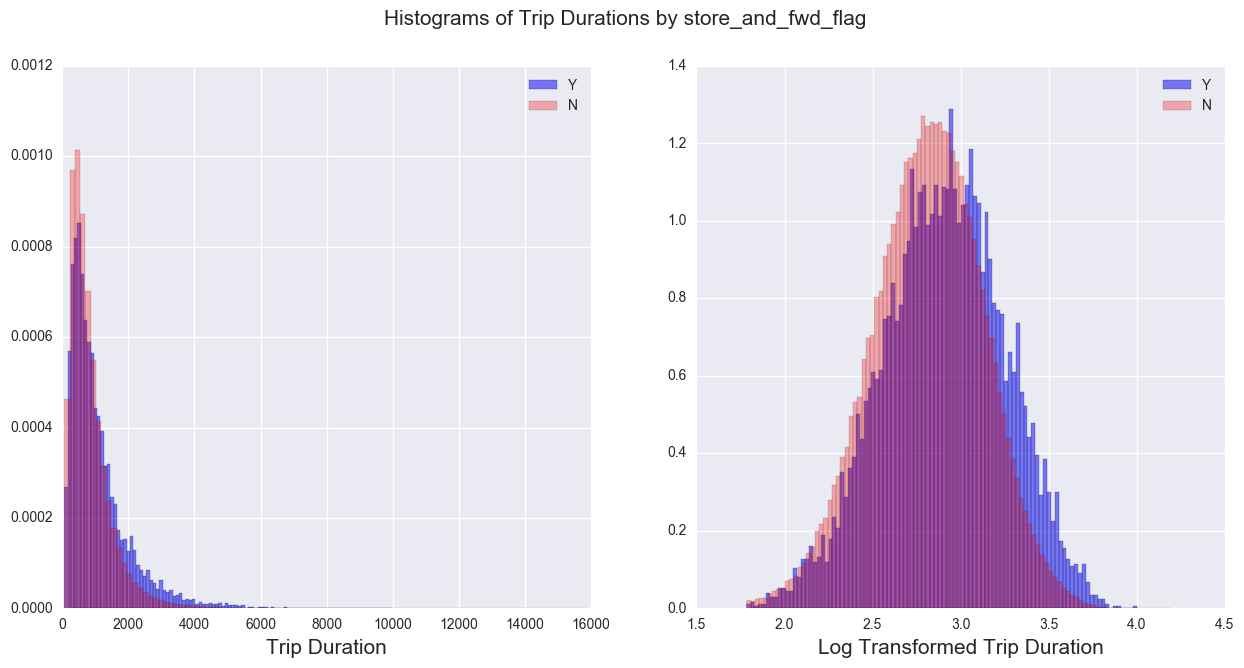

In [58]:
plt.figure(figsize=(15,7))


plt.subplot(1, 2, 1)
plt.hist(train[~train.trip_duration.isnull()][train.store_and_fwd_flag == 'Y'].trip_duration, 
         bins=100, normed = True, alpha = 0.5, color = 'blue', 
         label='Y')
plt.hist(train[~train.trip_duration.isnull()][train.store_and_fwd_flag == 'N'].trip_duration, 
         bins=100, normed = True, alpha = 0.3, color = 'red', 
         label= 'N')
plt.xlabel('Trip Duration', size = 15)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.log10(train[~train.trip_duration.isnull()][train.store_and_fwd_flag == 'Y'].trip_duration), 
         bins=100, normed = True, alpha = 0.5, color = 'blue', 
         label='Y')
plt.hist(np.log10(train[~train.trip_duration.isnull()][train.store_and_fwd_flag == 'N'].trip_duration), 
         bins=100, normed = True, alpha = 0.3, color = 'red', 
         label='N')
plt.xlabel('Log Transformed Trip Duration', size = 15)
plt.legend()

plt.suptitle('Histograms of Trip Durations by store_and_fwd_flag', size = 15)
plt.show()

Figure 3: The figure shows both original and log transformed distribution of trip durations in the train data when the store and fwd flag is Y and N. By visual inspection we can see that the mean and variance of both distributions is different. We need to check whether the difference is statistically significant

In [59]:
print "Mean of trip duration with store_and_fwd_flag = 'Y':", train[train.store_and_fwd_flag == 'Y'].trip_duration.mean()
print "Mean of trip duration with store_and_fwd_flag = 'N':", train[train.store_and_fwd_flag == 'N'].trip_duration.mean()

Mean of trip duration with store_and_fwd_flag = 'Y': 1091.53049013
Mean of trip duration with store_and_fwd_flag = 'N': 835.680857311


In [60]:
print "Std. dev for flag Y:", train[train.store_and_fwd_flag == 'Y'].trip_duration.std()
print "Std. dev for flag N:", train[train.store_and_fwd_flag == 'N'].trip_duration.std()

Std. dev for flag Y: 917.368030394
Std. dev for flag N: 651.218057154


In [61]:
print "Log-transformed Std. dev for flag Y:", np.log10(train[train.store_and_fwd_flag == 'Y'].trip_duration).std()
print "Log-transformed Std. dev for flag N:", np.log10(train[train.store_and_fwd_flag == 'N'].trip_duration).std()

Log-transformed Std. dev for flag Y: 0.347409129612
Log-transformed Std. dev for flag N: 0.315483093668


#### Hypothesis Testing

* Null Hypothesis (H0) - The means of the trip duration distributions are same

* Alternate Hypothesis (H1) - The means of the trip duration distributions are different  

Welch t-test with alpha = 1%

In [64]:
sc.ttest_ind(train[~train.trip_duration.isnull()][train.store_and_fwd_flag == 'Y'].trip_duration, 
             train[~train.trip_duration.isnull()][train.store_and_fwd_flag == 'N'].trip_duration,
             equal_var=False, nan_policy='propagate')

Ttest_indResult(statistic=24.684007314746143, pvalue=1.1824008903751348e-129)

In [65]:
sc.ttest_ind(np.log10(train[~train.trip_duration.isnull()][train.store_and_fwd_flag == 'Y'].trip_duration), 
             np.log10(train[~train.trip_duration.isnull()][train.store_and_fwd_flag == 'N'].trip_duration),
             equal_var=True, nan_policy='propagate')

Ttest_indResult(statistic=26.292245260099588, pvalue=2.5559501372164705e-152)

The welch t-test used for unequal variance and unequal sample size gives a p-value less than the threshold, the data provides evidence to reject the null hypothesis. The difference in trip duration means of the two distributions because of the store and forward flag is statistically significant. It seems that trips which have a longer durations often face connection issues

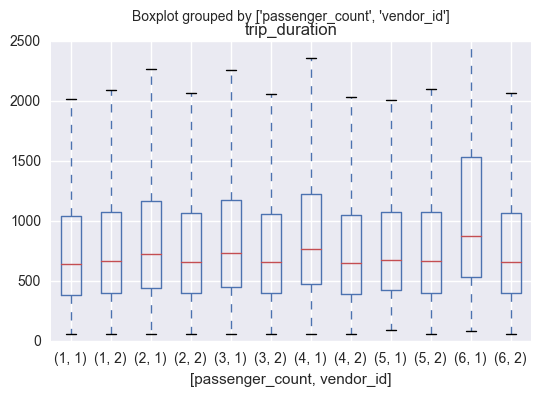

In [75]:
train[['trip_duration', 'passenger_count', 'vendor_id']].boxplot(by = ['passenger_count', 'vendor_id'])
plt.ylim(0,2500)
plt.show()

Figure 4: Passenger count does not have much effect on the trip duration. As seen from the figure above, the median and the inter quartile range is almost similar for all the passenger count. The median trip duration for vendor 1 with six passengers is high as compared to vendor 2. This may be just because the taxi company of vendor 1 is closer to customer accessible area. Even though this variable shows that there is some information about taxi trips with high trip duration, the data sample is low as compared to total data. More data will be required to support the inference.

### Lets aggregate the trips to census tract level to study the spatial patterns in data

The census tract in NYC cover 5-6 blocks on an average. The pickups and dropoffs are aggregated to census tracts to see meaningful visualizations

I am creating separate dataframes for pickups and dropoffs to study their spatial pattern

In [110]:
# The below code will spatially join the pickups and dropffs to census tract level 
# and create two files, one for pickup, other for dropoff

nyct = gp.read_file("./nyct2010_17c/nyct2010.shp")
nyct.to_crs(epsg=4326, inplace=True)
ct = nyct[['BoroCT2010', 'BoroName', 'geometry']]
ct.BoroCT2010 = ct.BoroCT2010.astype('int64')

train_pickups = train[['id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'trip_duration']]
train_dropoffs = train[['id', 'dropoff_datetime', 'passenger_count', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']]

train_pickups['lonlat']=zip(train_pickups.pickup_longitude,train_pickups.pickup_latitude)
train_pickups['geometry']=train_pickups[['lonlat']].applymap(lambda x:sh.geometry.Point(x))
train_pickups.drop(['lonlat'], axis=1, inplace=True)
crs = {'init': 'epsg:4326', 'no_defs': True}
train_pickups = gp.GeoDataFrame(train_pickups, crs=crs, geometry=train_pickups.geometry)

train_dropoffs['lonlat']=zip(train_dropoffs.dropoff_longitude,train_dropoffs.dropoff_latitude)
train_dropoffs['geometry']=train_dropoffs[['lonlat']].applymap(lambda x:sh.geometry.Point(x))
train_dropoffs.drop(['lonlat'], axis=1, inplace=True)
crs = {'init': 'epsg:4326', 'no_defs': True}
train_dropoffs = gp.GeoDataFrame(train_dropoffs, crs=crs, geometry=train_dropoffs.geometry)

train_pickups = gp.sjoin(ct, train_pickups)
train_dropoffs = gp.sjoin(ct, train_dropoffs )

train_pickups.reset_index(inplace=True, drop=True)
train_dropoffs.reset_index(inplace=True, drop=True)

train_pickups.drop(['index_right'], axis=1, inplace=True)
train_dropoffs.drop(['index_right'], axis=1, inplace=True)

# Creating files to save for later use
train_pickups.drop(['geometry', 'BoroName'], axis=1, inplace=True)
train_dropoffs.drop(['geometry', 'BoroName'], axis=1, inplace=True)
train_pickups.drop([u'pickup_datetime', u'passenger_count', u'pickup_longitude',  
                    u'pickup_latitude', u'trip_duration'], axis = 1, inplace = True)
train_dropoffs.drop([u'dropoff_datetime', u'passenger_count', u'dropoff_longitude',  
                    u'dropoff_latitude', u'trip_duration'], axis = 1, inplace = True)

train_pickups.to_csv("./Cleaned_data/tp_full.csv")
train_dropoffs.to_csv("./Cleaned_data/td_full.csv")

# Aggregate at census tract level
tp_count = train_pickups.groupby('BoroCT2010').agg({'id':'count'})
td_count = train_dropoffs.groupby('BoroCT2010').agg({'id':'count'})

tp_count.reset_index(inplace=True)
td_count.reset_index(inplace=True)

# Creating a geo-dataframe to plot
tp_count = pd.merge(tp_count, ct, on='BoroCT2010', how='left')
td_count = pd.merge(td_count, ct, on='BoroCT2010', how='left')

crs = {'init': 'epsg:4326', 'no_defs': True}
tp_count = gp.GeoDataFrame(tp_count, crs=crs, geometry=tp_count.geometry)
td_count = gp.GeoDataFrame(td_count, crs=crs, geometry=td_count.geometry)

The central park has some values present in it. This becasue of the GPS error. For my analysis, I have split the values of the pickups and dropoffs at central parks to its neighbours equally. There is a better way to split points according to the lat long and the nearest census tract but that would take a lot of processing.

In [280]:
## Find neighbours of the central park ct by using the pysal library and queen contiguity
tp_count.to_file("./Cleaned_data/tp_count.shp")
filepath ="./Cleaned_data/tp_count.shp"

W = ps.queen_from_shapefile(filepath, idVariable='BoroCT2010')

cp_neigh = W.neighbors[1014300]

val1 = int(tp_count[tp_count.BoroCT2010 == 1014300].id / len(cp_neigh))
val2 = int(td_count[td_count.BoroCT2010 == 1014300].id / len(cp_neigh))

tp_count.set_index('BoroCT2010', inplace=True)
td_count.set_index('BoroCT2010', inplace=True)


for cp_n in cp_neigh:
    tp_count.loc[cp_n, 'id'] = tp_count.loc[cp_n, 'id'] + val1
    td_count.loc[cp_n, 'id'] = td_count.loc[cp_n, 'id'] + val2
    

tp_count.reset_index(inplace=True)
td_count.reset_index(inplace=True)

## Remove central park from the dataset
tp_count.drop(tp_count[tp_count.BoroCT2010 == 1014300].index, axis=0, inplace=True)
td_count.drop(td_count[td_count.BoroCT2010 == 1014300].index, axis=0, inplace=True)

## Now lets plot the census tracts with pickup and dropoff values

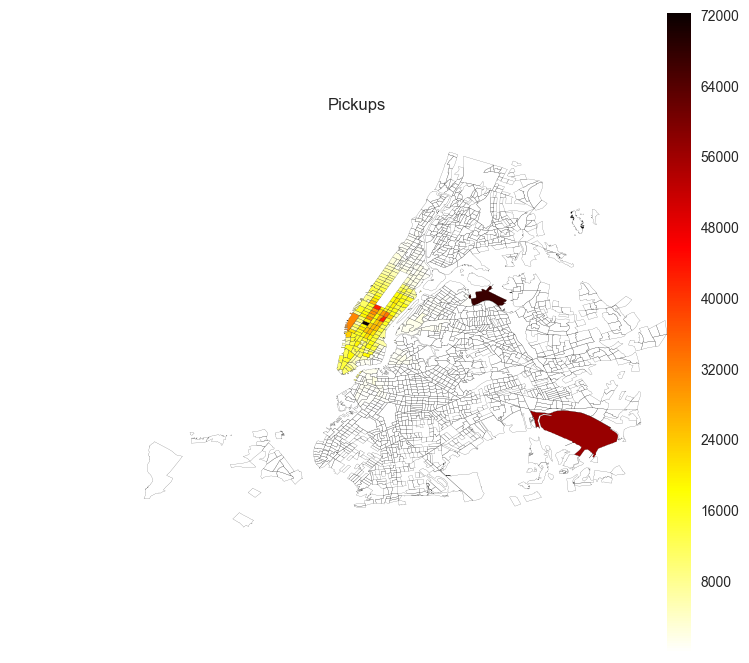

In [281]:
vmin, vmax = tp_count.id.min(), tp_count.id.max()

ax = tp_count.plot(column='id', colormap='hot_r', vmin=vmin, vmax=vmax, linewidth = 0.1, alpha = 1, figsize=(8,8))
ax.set_axis_off()
ax.set_title('Pickups')
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()

Figure 4: The above figure shows the taxi pickups in NYC. The missing areas don't have pickus. It is clearly seen that most pickups are in Manhattan, the two airports and little in downtown brooklyn. The pickups are extremly high at airports and low in the outer boroughs. It is resonable that the pickups by yellow taxis are low in outer boroughs since they are mostly serving the Manhattan borough and Boro Taxis serve the outer boroughs.

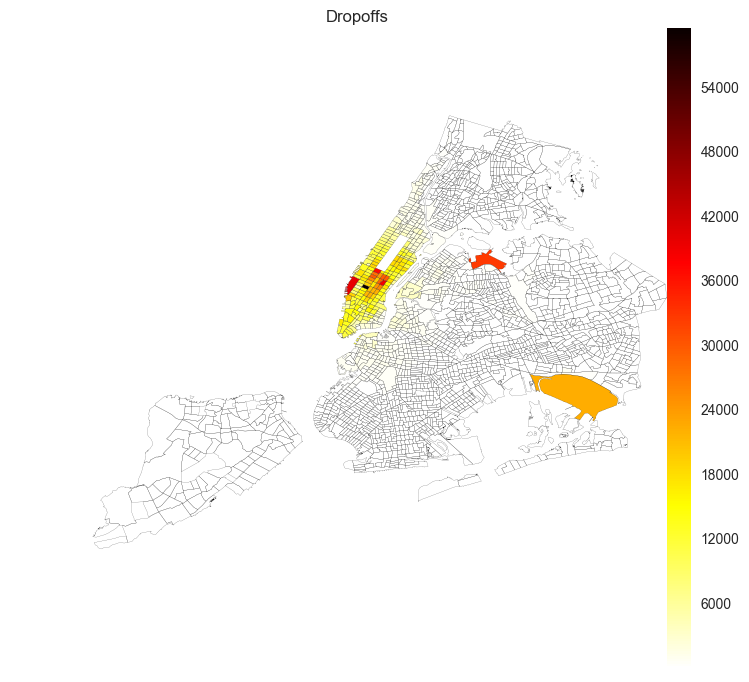

In [282]:
vmin, vmax = td_count.id.min(), td_count.id.max()

ax = td_count.plot(column='id', colormap='hot_r', vmin=vmin, vmax=vmax, linewidth = 0.1, alpha = 1, figsize=(8,8))
ax.set_axis_off()
ax.set_title('Dropoffs')

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()

Figure 5: The above figure shows the taxi dropoffs in NYC. The missing areas don't have dropoffs. It is clearly seen that most dropoffs are in Manhattan, the two airports and little in downtown brooklyn. The dropoffs are extremly high at airports, Manhattan and low in the outer boroughs.

Maps from figure 4 and figure 5 suggest that the yellow taxi is majorly serving Manhattan and the airports. The airport trips are extremely high and I am eliminating the trips of airports and outer boroughs to concentrate on Manhattan. The analysis on Manhattan would give more granular idea about the taxi usage, since yellow taxi is mostly used in Manhattan. The sample data on outer boroughs is low and it deviates the analysis   

In [283]:
tp_count = tp_count[tp_count.BoroName == 'Manhattan']
td_count = td_count[td_count.BoroName == 'Manhattan']

tp_count.reset_index(inplace=True, drop=True)
td_count.reset_index(inplace=True, drop=True)

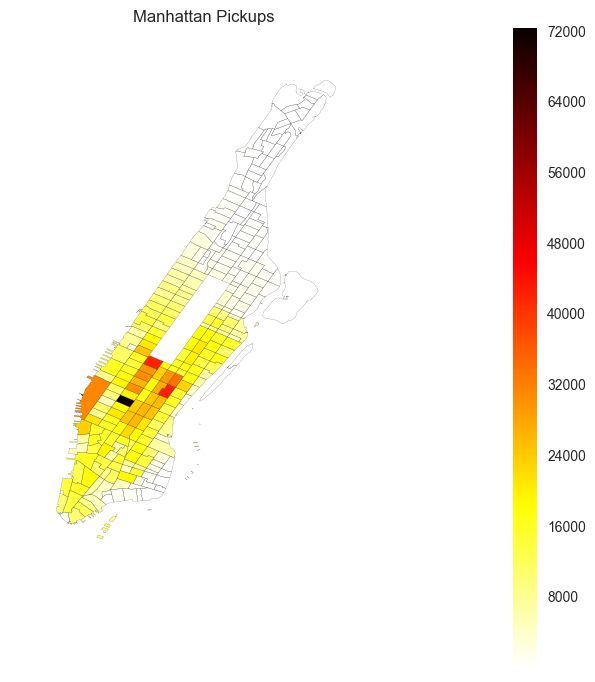

In [284]:
vmin, vmax = tp_count.id.min(), tp_count.id.max()

ax = tp_count.plot(column='id', colormap='hot_r', vmin=vmin, vmax=vmax, linewidth = 0.1, alpha = 1, figsize=(8,8))
ax.set_axis_off()
ax.set_title('Manhattan Pickups')
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()

Figure 6: The map shows that the pickups are concentrated near midtown manhattan, mainly near penn station and grant central, highline.

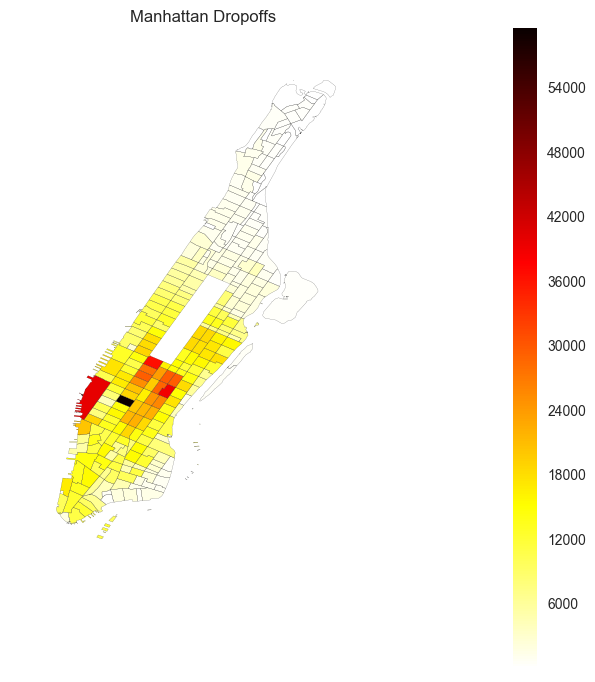

In [285]:
vmin, vmax = td_count.id.min(), td_count.id.max()

ax = td_count.plot(column='id', colormap='hot_r', vmin=vmin, vmax=vmax, linewidth = 0.1, alpha = 1, figsize=(8,8))
ax.set_axis_off()
ax.set_title('Manhattan Dropoffs')
# add colorbar
fig = ax.get_figurTe()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()

Figure 7: The map shows that the dropoffs are concentrated near midtown manhattan, mainly near penn station and grant central, highline. There are some dropoffs near upper east and west side

This visualization just gives a general idea about the overall pickups and dropoffs in NYC.

I have created 3 notebooks to analyse the dataset

# Notebook - 'Hourly pattern Spatial clustering'

This notebook analyses the spatial and temporal patterns in taxi dataset like weekly, monthly, hourly pickups and dropoffs
The Manhattan census tracts are clustered according to these pattern variables. 

# Notebook - 'Hotspots_Coldspots_Analysis'

According to Tobler's first law of geography - "everything is related to everything else, but near things are more related than distant things."


The taxi pickups, dropoffs, trip durations values within a census tract are related to its neighbouring census tracts. This spatial autocorrelation is studied in this notebook. This is a part of Exploratory Spatial Data Analysis (ESDA). I have used these methods to find the hot spots and cold spots in Manhattan for the different variables  

# Notebook - 'Regression'

Literature review of the taxi-dataset analysis shows that taxi data has been used in prediction of unment demand. (NYU-CUSP Capstone) https://medium.com/@NYCTLC/students-use-tlc-data-to-study-unmet-taxi-demand-and-find-ideal-spots-for-taxi-relief-stands-644e40ebe11a

The taxi dataset is used to predict the taxi trip duration from the taxi data. The notebook shows an implementation of a predictive model.

# Conclusion

The yellow taxi data set has a vast amount of information, this dataset can be merged with the green, FHV taxi data, census and LODHES data to study the characteristics of a place.

If merged with the data available with any additional proprietary dataset we can generate additional value in terms of advertisement revenue, consumer segmentation, targeted marketing and so on.